In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt

In [27]:
def load_cv_results(models, base_dir, years=[2015, 2016, 2017], ext='', fluxes=False):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    radar_idx = dict()
    
    for i, m in enumerate(models):

        # load predictions
        model_dir = osp.join(base_dir, f'nested_cv_{m}')
        result_list = []
        radar_idx_list = []
        for fold, y in enumerate(years):
            file = osp.join(model_dir, f'test_{y}', 'final_evaluation', 'final_1', f'results{ext}.csv')
            df = pd.read_csv(file)
            df['fold'] = fold
            result_list.append(df)
            
            radar_path = osp.join(osp.dirname(file), 'radar_index.pickle')
            if osp.isfile(radar_path):
                with open(radar_path, 'rb') as f:
                    radar_idx_list.append(pickle.load(f))
        radar_idx[m] = radar_idx_list
        results[m] = pd.concat(result_list)
        
        print(f'successfully loaded results for {m}')
        
        # load fluxes
        if fluxes and 'Flux' in m:
            m_fluxes = [dict(), dict()]
            for fold, y in enumerate(years):
                sub_dir = osp.join(model_dir, f'test_{y}', 'final_evaluation', 'final_1')
                          
                with open(osp.join(sub_dir, f'radar_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[0][fold] = pickle.load(f)
                          
                with open(osp.join(sub_dir, f'model_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[1][fold] = pickle.load(f)
    
            all_fluxes[m] = m_fluxes

    return results, bird_scales, all_fluxes, radar_idx

In [3]:
def compute_rmse(m, results, groupby='fold', threshold=0, km2=True):
    
    ext = '_km2' if km2 else ''
        
    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}')
    rmse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean).apply(np.sqrt)
    rmse = rmse.reset_index(name='rmse')
    rmse['model'] = m
    
    print(rmse)
    
    return rmse

In [33]:
def plot_fluxes(voronoi, G, all_fluxes, results, fold=0, model=1, context=24, horizon=64, bird_scale=1, 
                net_fluxes=False, abm=False, ax=None, crs=None, max_flux=0):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    if abm:
        f = np.concatenate([f[..., :horizon+1] for f in all_fluxes.values()], axis=-1)
        mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes))])
    else:
        print(len(all_fluxes[fold]), results.horizon.unique())
        if model:
            f = torch.cat([f for f in all_fluxes[fold].values()], dim=-1).detach().numpy()
        else:
            f = torch.cat([f[..., context:context+horizon] for f in all_fluxes[fold].values()], dim=-1).detach().numpy()
        mask = np.concatenate([results.query(f'seqID == {i} & horizon >= {context}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[fold]))])


    #radars = results.radar.unique()
    radars = voronoi.radar.values
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask]) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask])
            #print(val)
            if net_fluxes:
                val = val - val2
            if val > 0 and i !=j :
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    max_flux = max(max_flux, fluxes.max())
    norm = plt.Normalize(0, max_flux)
    #print(fluxes.min(), fluxes.max())
    #print(nx.get_edge_attributes(G_new, 'flux'))
    edge_colors = cmap(norm(fluxes))

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    if abm:
        ax.set(title='averaged simulated fluxes between radars')
    else:
        ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, ax, max_flux

In [4]:
base_dir = '/home/fiona/birdMigration/results'

In [13]:
models = ['GBT', 'LocalMLP', 'LocalLSTM']
models = ['LocalLSTM']
results, bird_scales, _, radar_idx = load_cv_results(models, base_dir)
results2, bird_scales2, _, radar_idx2 = load_cv_results(['GBT'], base_dir)

successfully loaded results for LocalLSTM
successfully loaded results for GBT


In [28]:
results3, bird_scales3, fluxes3, radar_idx3 = load_cv_results(['LocalMLP', 'LocalLSTM', 'FluxGraphLSTM'], base_dir, ext='_fixedT0', fluxes=True)

successfully loaded results for LocalMLP
successfully loaded results for LocalLSTM
successfully loaded results for FluxGraphLSTM


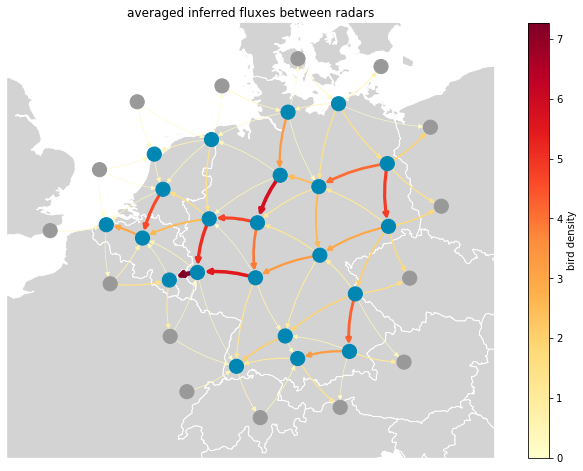

In [26]:
m = 'FluxGraphLSTM'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
ax.set_extent([0, 17, 45.5, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_new, ax, max_flux = plot_fluxes(voronoi, G, fluxes3[m][0], results3[m], fold=0, 
                         encoder=1, bird_scale=1,
                        abm=False, ax=ax, crs=crs.proj4_init)

In [32]:
results3[m].seqID.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

85 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]


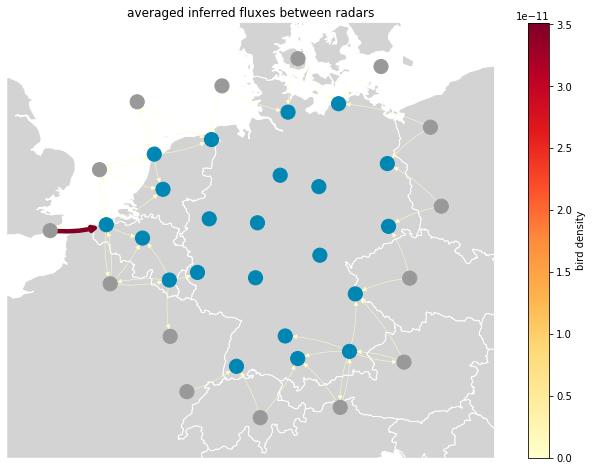

In [35]:
m = 'FluxGraphLSTM'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=15/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
ax.set_extent([0, 17, 45.5, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_new, ax, max_flux = plot_fluxes(voronoi, G, fluxes3[m][1], results3[m], fold=0, 
                         model=1, bird_scale=1,
                        abm=False, ax=ax, crs=crs.proj4_init)

In [39]:
results3['FluxGraphLSTM'].flux.max()

1.4096488e-08

In [36]:
seq3 = results3['FluxGraphLSTM'].query('seqID == 34 & radar == "deess" & fold == 0')

,Unnamed: 0,gt,gt_km2,prediction,prediction_km2,night,radar,seqID,tidx,datetime,horizon,missing,trial,flux,source/sink,influx,outflux,residual,residual_km2,fold
111232,111232,620342.44,26.359375,NaN,NaN,True,deess,34,919,2015-09-08 19:00:00+00:00,0,False,1,NaN,NaN,NaN,NaN,NaN,NaN,0
111233,111233,618398.20,26.276760,NaN,NaN,True,deess,34,920,2015-09-08 20:00:00+00:00,1,False,1,NaN,NaN,NaN,NaN,NaN,NaN,0
111234,111234,589740.56,25.059050,NaN,NaN,True,deess,34,921,2015-09-08 21:00:00+00:00,2,False,1,NaN,NaN,NaN,NaN,NaN,NaN,0
111235,111235,560985.70,23.837208,NaN,NaN,True,deess,34,922,2015-09-08 22:00:00+00:00,3,False,1,NaN,NaN,NaN,NaN,NaN,NaN,0
111236,111236,568451.40,24.154438,NaN,NaN,True,deess,34,923,2015-09-08 23:00:00+00:00,4,False,1,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111315,111315,0.00,0.000000,10569.262,0.449105,False,deess,34,1002,2015-09-12 06:00:00+00:00,83,False,1,0.0,-0.001138,0.0,0.0,-10569.262,-0.449105,0
111316,111316,0.00,0.000000,10105.984,0.429420,False,deess,34,1003,2015-09-12 07:00:00+00:00,84,False,1,0.0,-0.000089,0.0,0.0,-10105.984,-0.429420,0
111317,111317,0.00,0.000000,9773.979,0.415312,False,deess,34,1004,2015-09-12 08:00:00+00:00,85,False,1,0.0,-0.000064,0.0,0.0,-9773.979,-0.415312,0
111318,111318,0.00,0.000000,9733.758,0.413603,False,deess,34,1005,2015-09-12 09:00:00+00:00,86,False,1,0.0,-0.000008,0.0,0.0,-9733.758,-0.413603,0


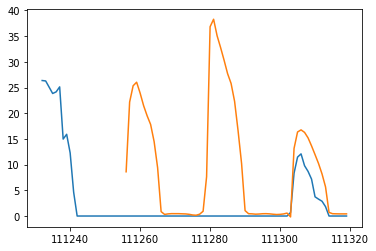

In [37]:
fig, ax = plt.subplots()
ax.plot(seq3.gt_km2)
ax.plot(seq3.prediction_km2)

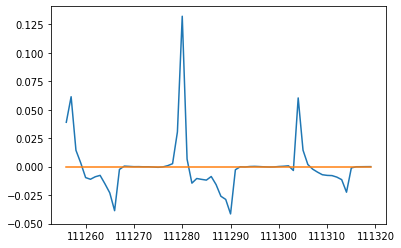

In [38]:
fig, ax = plt.subplots()
ax.plot(seq3['source/sink'])
ax.plot(seq3['flux'])

In [23]:
seq = results['LocalLSTM'].query('seqID == 34 & radar == "deess" & fold == 0')
seq2 = results2['GBT'].query('seqID == 34 & radar == "deess" & fold == 0')

In [24]:
seq

,Unnamed: 0,gt,gt_km2,prediction,prediction_km2,night,radar,seqID,tidx,datetime,horizon,missing,trial,residual,residual_km2,fold
66352,66352,1.949970,1.949970,NaN,NaN,True,deess,34,1039,2015-09-13 19:00:00+00:00,0,False,1,NaN,NaN,0
66353,66353,1.584152,1.584152,NaN,NaN,True,deess,34,1040,2015-09-13 20:00:00+00:00,1,False,1,NaN,NaN,0
66354,66354,0.077521,0.077521,NaN,NaN,True,deess,34,1041,2015-09-13 21:00:00+00:00,2,False,1,NaN,NaN,0
66355,66355,0.390804,0.390804,NaN,NaN,True,deess,34,1042,2015-09-13 22:00:00+00:00,3,False,1,NaN,NaN,0
66356,66356,0.154121,0.154121,NaN,NaN,True,deess,34,1043,2015-09-13 23:00:00+00:00,4,False,1,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66435,66435,0.000000,0.000000,0.105330,0.105330,False,deess,34,1122,2015-09-17 06:00:00+00:00,83,False,1,-0.105330,-0.105330,0
66436,66436,0.000000,0.000000,0.107934,0.107934,False,deess,34,1123,2015-09-17 07:00:00+00:00,84,False,1,-0.107934,-0.107934,0
66437,66437,0.000000,0.000000,-0.097685,-0.097685,False,deess,34,1124,2015-09-17 08:00:00+00:00,85,False,1,0.097685,0.097685,0
66438,66438,0.000000,0.000000,0.040230,0.040230,False,deess,34,1125,2015-09-17 09:00:00+00:00,86,False,1,-0.040230,-0.040230,0


In [19]:
seq2

,Unnamed: 0,gt_km2,prediction_km2,gt,prediction,night,radar,seqID,tidx,datetime,trial,horizon,missing,residual_km2,residual,fold
64416,64416,0.000000,NaN,0.00,NaN,False,deess,33,1414,2015-09-29 10:00:00+00:00,1,0,False,NaN,NaN,0
64417,64417,0.000000,NaN,0.00,NaN,False,deess,33,1415,2015-09-29 11:00:00+00:00,1,1,False,NaN,NaN,0
64418,64418,0.000000,NaN,0.00,NaN,False,deess,33,1416,2015-09-29 12:00:00+00:00,1,2,False,NaN,NaN,0
64419,64419,0.000000,NaN,0.00,NaN,False,deess,33,1417,2015-09-29 13:00:00+00:00,1,3,False,NaN,NaN,0
64420,64420,0.000000,NaN,0.00,NaN,False,deess,33,1418,2015-09-29 14:00:00+00:00,1,4,False,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64499,64499,15.011149,22.572191,353272.90,531214.714095,True,deess,33,1497,2015-10-02 21:00:00+00:00,1,83,False,-7.561041,-177941.807845,0
64500,64500,16.305977,22.484513,383745.44,529151.303488,True,deess,33,1498,2015-10-02 22:00:00+00:00,1,84,False,-6.178536,-145405.865988,0
64501,64501,16.860487,21.424652,396795.28,504208.489443,True,deess,33,1499,2015-10-02 23:00:00+00:00,1,85,False,-4.564165,-107413.208193,0
64502,64502,15.056759,15.610029,354346.28,367366.959036,True,deess,33,1500,2015-10-03 00:00:00+00:00,1,86,False,-0.553270,-13020.677786,0


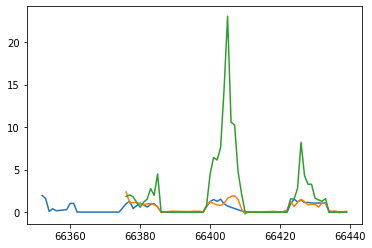

In [25]:
fig, ax = plt.subplots()
ax.plot(seq.gt_km2)
ax.plot(seq.prediction_km2)
ax.plot(seq2.prediction_km2)

In [10]:
rmse = pd.concat([compute_rmse(m, r) for m, r in results3.items()])
rmse

   fold       rmse     model
0     0  10.214454  LocalMLP
1     1   9.404358  LocalMLP
2     2   8.605254  LocalMLP
   fold      rmse      model
0     0  9.605186  LocalLSTM
1     1  8.555128  LocalLSTM
2     2  7.272788  LocalLSTM
   fold      rmse          model
0     0  8.788097  FluxGraphLSTM
1     1  7.861211  FluxGraphLSTM
2     2  6.167708  FluxGraphLSTM


,fold,rmse,model
0,0,10.214454,LocalMLP
1,1,9.404358,LocalMLP
2,2,8.605254,LocalMLP
0,0,9.605186,LocalLSTM
1,1,8.555128,LocalLSTM
2,2,7.272788,LocalLSTM
0,0,8.788097,FluxGraphLSTM
1,1,7.861211,FluxGraphLSTM
2,2,6.167708,FluxGraphLSTM


    horizon       rmse     model
0         0        NaN  LocalMLP
1         1        NaN  LocalMLP
2         2        NaN  LocalMLP
3         3        NaN  LocalMLP
4         4        NaN  LocalMLP
5         5        NaN  LocalMLP
6         6        NaN  LocalMLP
7         7        NaN  LocalMLP
8         8        NaN  LocalMLP
9         9        NaN  LocalMLP
10       10        NaN  LocalMLP
11       11        NaN  LocalMLP
12       12        NaN  LocalMLP
13       24  29.804317  LocalMLP
14       25  34.808964  LocalMLP
15       26  34.883525  LocalMLP
16       27  37.703476  LocalMLP
17       28  38.302829  LocalMLP
18       29  36.049123  LocalMLP
19       30  35.187802  LocalMLP
20       31  34.077786  LocalMLP
21       32  32.374662  LocalMLP
22       33  34.865147  LocalMLP
23       34  37.705536  LocalMLP
24       35  38.478327  LocalMLP
25       36  29.731813  LocalMLP
26       48  29.291991  LocalMLP
27       49  34.324880  LocalMLP
28       50  34.069334  LocalMLP
29       5

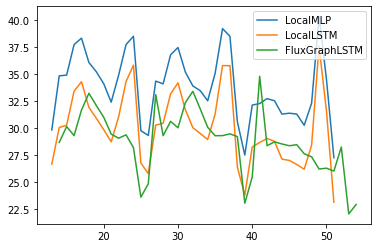

In [17]:
rmse = pd.concat([compute_rmse(m, r, groupby='horizon', threshold=20) for m, r in results3.items()])

fig, ax = plt.subplots()
for m in rmse.model.unique():
    df = rmse.query(f'model == "{m}"')
    ax.plot(df.rmse, label=m)
ax.legend()

In [12]:
rmse = pd.concat([compute_rmse(m, r, threshold=40) for m, r in results3.items()])
rmse

   fold       rmse     model
0     0  65.133440  LocalMLP
1     1  65.083618  LocalMLP
2     2  49.227252  LocalMLP
   fold       rmse      model
0     0  59.992088  LocalLSTM
1     1  58.885602  LocalLSTM
2     2  41.780986  LocalLSTM
   fold       rmse          model
0     0  60.373212  FluxGraphLSTM
1     1  55.320113  FluxGraphLSTM
2     2  40.712884  FluxGraphLSTM


,fold,rmse,model
0,0,65.133440,LocalMLP
1,1,65.083618,LocalMLP
2,2,49.227252,LocalMLP
0,0,59.992088,LocalLSTM
1,1,58.885602,LocalLSTM
2,2,41.780986,LocalLSTM
0,0,60.373212,FluxGraphLSTM
1,1,55.320113,FluxGraphLSTM
2,2,40.712884,FluxGraphLSTM


In [6]:
rmse = pd.concat([compute_rmse(m, r) for m, r in results.items()])
rmse

   fold      rmse      model
0     0  9.184107  LocalLSTM
1     1  8.175275  LocalLSTM
2     2  6.754729  LocalLSTM


,fold,rmse,model
0,0,9.184107,LocalLSTM
1,1,8.175275,LocalLSTM
2,2,6.754729,LocalLSTM


In [7]:
rmse = pd.concat([compute_rmse(m, r) for m, r in results.items()])
rmse

   fold      rmse model
0     0  8.220885   GBT
1     1  8.449771   GBT
2     2  6.847134   GBT
   fold      rmse     model
0     0  9.638630  LocalMLP
1     1  9.144690  LocalMLP
2     2  8.071226  LocalMLP


,fold,rmse,model
0,0,8.220885,GBT
1,1,8.449771,GBT
2,2,6.847134,GBT
0,0,9.638630,LocalMLP
1,1,9.144690,LocalMLP
2,2,8.071226,LocalMLP
